In [14]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim
from datetime import datetime, date

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
import scoping.models as sm
from django.contrib.auth.models import User
from tmv_app.models import *
import twitter.models as tm
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField
from django.db.models.functions import Trunc, TruncDay

from parliament.utils import merge_utterance_paragraphs

In [2]:
df_twittersearches = pd.DataFrame(data=tm.TwitterSearch.objects.all().order_by('id').values())
pd.set_option('display.max_rows', 100)
df_twittersearches

id                                   string  \
0     1                                    kohle   
1     2                          Kohlekommission   
2     3                                     coal   
3     4                         @badulrichmartha   
4     5                                sustainab   
5     6                           geoengineering   
6     7                    "climate engineering"   
7     8                     "negative emissions"   
8     9                 "carbon dioxide removal"   
9    10                            "co2 removal"   
10   11                         "carbon removal"   
11   12                      "co2 sequestration"   
12   13                   "carbon sequestration"   
13   14           "carbon dioxide sequestration"   
14   15                 "greenhouse gas removal"   
15   16                            "ghg removal"   
16   17                  "planetary engineering"   
17   18                                #CO2Preis   
18   19                               #CO2Preise   
19   20                               #CO2Steuer   
20   21                              #CO2Steuern   
21   22                               #CO2Abgabe   
22   23                                   #EUETS   
23   24                                     #ETS   
24   25                         #Emissionshandel   
25   26                       #Klimaschutzgesetz   
26   27                         #Kohlekommission   
27   28                           #Kohleausstieg   
28   29                              #Klimakrise   
29   30                             #Klimawandel   
30   31                             #Klimaschutz   
31   32                             #Hambibleibt   
32   33                              "co2 preis"   
33   34                             "co2 steuer"   
34   35                        Klimaschutzgesetz   
35   36                        Zertifikatehandel   
36   37                              Klimasteuer   
37   39                                co2 preis   
38   41                            carbonpricing   
39   43                            co2bepreisung   
40   46                           @GretaThunberg   
41   48                          "Kohleausstieg"   
42   49                          #Kohlekopromiss   
43   51                                co2steuer   
44   55                              #co2 steuer   
45   57                              wasserstoff   
46   58                                 hydrogen   
47   59                                    Klima   
48   60                             Erderwärmung   
49   61                        globale Erwärmung   
50   62                          Treibhauseffekt   
51   63                                kohlefrei   
52   68                        #FridaysForFuture   
53   69                             Energiewende   
54   70                               Wärmewende   
55   71                            Verkehrswende   
56   72                           Industriewende   
57   73                                     #FFF   
58   77                            #Klimapolitik   
59   78                             #EUGreenDeal   
60   79                       climate mitigation   
61   80                       climate adaptation   
62   81                           climate policy   
63   82                           climate action   
64   83                         "climate change"   
65   84                         "carbon pricing"   
66   85                           "carbon price"   
67   86                              "co2 price"   
68   87                            "co2 pricing"   
69   88                      "emissions trading"   
70   89                       "emission trading"   
71   90                              Klimaschutz   
72   91                           Klimaanpassung   
73   92                             Klimapolitik   
74   93                              Klimawandel   
75   94              Klima anpassungKlimapolitik   
7

In [3]:
# Export searches for the following ids:
search_ids_to_export = [6,7,8,9,10, 11, 12, 13,14,15,16, 17]

# export search results

In [ ]:
#from django.core.management import call_command

#search_id = 1
#call_command('export_search', search_id, '--path', '/usr/local/apsis/slowhome/muef/twitter_exports/')

In [ ]:
# done in tmv/BasicBrowser:
# python manage.py export_search 59 --path /usr/local/apsis/slowhome/muef/twitter_exports/

# for compressing:
# zip zipfile.zip source1.end source2.end ...
# zip zipfile.zip -r dir

In [7]:
df_twittersearches = pd.DataFrame(data=tm.TwitterSearch.objects.filter(id__in=search_ids_to_export).order_by('id').values())
df_twittersearches

id                          string                   scrape_fetched  \
0    6                  geoengineering 2021-11-07 16:57:55.230914+00:00   
1    7           "climate engineering" 2021-11-07 16:57:55.230914+00:00   
2    8            "negative emissions" 2021-11-07 16:57:55.230914+00:00   
3    9        "carbon dioxide removal" 2021-11-07 16:57:55.230914+00:00   
4   10                   "co2 removal" 2021-11-07 16:57:55.230914+00:00   
5   11                "carbon removal" 2021-11-07 16:57:55.230914+00:00   
6   12             "co2 sequestration" 2021-11-07 16:57:55.230914+00:00   
7   13          "carbon sequestration" 2021-11-07 16:57:55.230914+00:00   
8   14  "carbon dioxide sequestration" 2021-11-07 16:57:55.230914+00:00   
9   15        "greenhouse gas removal" 2021-11-07 16:57:55.230914+00:00   
10  16                   "ghg removal" 2021-11-07 16:57:55.230914+00:00   
11  17         "planetary engineering" 2021-11-07 16:57:55.230914+00:00   

                              until                            since  \
0  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
1  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
2  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
3  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
4  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
5  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
6  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
7  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
8  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
9  2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
10 2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   
11 2021-11-07 16:57:55.230914+00:00 2009-11-05 09:31:44.480805+00:00   

                       search_since  project_id  
0  2021-04-15 14:34:24.751810+00:00           2  
1  2021-04-15 14:34:24.751810+00:00           2  
2  2021-04-15 14:34:24.751810+00:00           2  
3  2021-04-15 14:34:24.751810+00:00           2  
4  2021-04-15 14:34:24.751810+00:00           2  
5  2021-04-15 14:34:24.751810+00:00           2  
6  2021-04-15 14:34:24.751810+00:00           2  
7  2021-04-15 14:34:24.751810+00:00           2  
8  2021-04-15 14:34:24.751810+00:00           2  
9  2021-04-15 14:34:24.751810+00:00           2  
10 2021-04-15 14:34:24.751810+00:00           2  
11 2021-04-15 14:34:24.751810+00:00           2

In [8]:
df_twittersearches["string"].values

array(['geoengineering', '"climate engineering"', '"negative emissions"',
       '"carbon dioxide removal"', '"co2 removal"', '"carbon removal"',
       '"co2 sequestration"', '"carbon sequestration"',
       '"carbon dioxide sequestration"', '"greenhouse gas removal"',
       '"ghg removal"', '"planetary engineering"'], dtype=object)

In [68]:
def export_tweets(tweets, path, name):
    
    from django.contrib.postgres.aggregates.general import ArrayAgg
    from django.core.serializers.json import DjangoJSONEncoder
    from django.core.serializers import serialize
    import json

    n = tweets.count()

    print(f"{n} tweets")

    exclude_fields = [
        'api_got','scrape_got','fetched', 'replies','retweets',
        'twitterbasemodel_ptr','searches','retweeted_by'
        ]
    fields = [x.name for x in tm.Status._meta.get_fields() if x.name not in exclude_fields]
    fields.append('retweeted_by_user_id')

    tweet_values = tweets.prefetch_related('retweeted_by').annotate(
        retweeted_by_user_id=ArrayAgg('retweeted_by')
    ).values(*fields)
    with open(os.path.join(path, f'{name}_tweets.json'),'w') as f:
        f.write(json.dumps(list(tweet_values),cls=DjangoJSONEncoder))
    #with open(os.path.join(path, f'{name}_users.json'),'w') as f:
    #    f.write(serialize('json',users,cls=DjangoJSONEncoder))
            
    print("Done")

In [10]:
all_tweets_geoeng = tm.Status.objects.filter(searches__in=search_ids_to_export)
all_tweets_geoeng.count()

1672588

In [69]:
#export_tweets(all_tweets_geoeng, "/usr/local/apsis/slowhome/muef/twitter_exports/", "geoengineering_tweets")

1387022 tweets, 510 users
Done


In [11]:
# analysis

In [28]:
update_counts = False
include_retweets = True

ts = search_ids_to_export
tweets = tm.Status.objects.filter(searches__in=ts)

if include_retweets:
    filename_ext = '+RT'
else:
    tweets = tweets.filter(retweeted_status__isnull=True).exclude(text__regex="^RT @")
    filename_ext = '-RT'

if update_counts:
    
    daily_counts = tweets.annotate(day=Trunc('created_at', 'day')).values('day', 'searches__string').annotate(sum=Count('id'))
    daily_counts_df = pd.DataFrame(data=daily_counts)
    daily_counts_df = daily_counts_df.set_index(["day", "searches__string"]).unstack().fillna(0).sort_index()
    daily_counts_df.columns = daily_counts_df.columns.droplevel()
    
    filename = "tweet-counts/Tweet_counts_by_day_geoeng_{}{}.csv".format(datetime.today().strftime('%Y-%m-%d'), filename_ext)
    daily_counts_df.to_csv(filename)
    print("Saved to ", filename)
    
else:
    date_str = "2021-11-08"
 #   monthly_counts_df = pd.read_csv("tweet-counts/Tweet_counts_by_month_{}{}.csv".format(date_str, filename_ext), index_col=0, parse_dates=[0])
    #monthly_counts_df.index = pd.to_datetime(monthly_counts_df.index)
    daily_counts_df = pd.read_csv("tweet-counts/Tweet_counts_by_day_geoeng_{}{}.csv".format(date_str, filename_ext), index_col=0, parse_dates=[0])
    print('Loaded count data from file', "Tweet_counts_by_day_geoeng_{}{}.csv".format(date_str, filename_ext))

Loaded count data from file Tweet_counts_by_day_geoeng_2021-11-08+RT.csv


In [29]:
daily_counts_df

"carbon dioxide removal"  \
day                                                   
2009-11-05 00:00:00+00:00                       0.0   
2009-11-06 00:00:00+00:00                       0.0   
2009-11-07 00:00:00+00:00                       0.0   
2009-11-08 00:00:00+00:00                       0.0   
2009-11-09 00:00:00+00:00                       0.0   
...                                             ...   
2021-11-04 00:00:00+00:00                      11.0   
2021-11-05 00:00:00+00:00                      33.0   
2021-11-06 00:00:00+00:00                       6.0   
2021-11-07 00:00:00+00:00                       0.0   
NaT                                             3.0   

                           "carbon dioxide sequestration"  "carbon removal"  \
day                                                                           
2009-11-05 00:00:00+00:00                             0.0               0.0   
2009-11-06 00:00:00+00:00                             0.0               0.0   
2009-11-07 00:00:00+00:00                             0.0               0.0   
2009-11-08 00:00:00+00:00                             1.0               0.0   
2009-11-09 00:00:00+00:00                             0.0               0.0   
...                                                   ...               ...   
2021-11-04 00:00:00+00:00                             1.0             106.0   
2021-11-05 00:00:00+00:00                             0.0              93.0   
2021-11-06 00:00:00+00:00                             0.0              72.0   
2021-11-07 00:00:00+00:00                             0.0               0.0   
NaT                                                   0.0              39.0   

                           "carbon sequestration"  "climate engineering"  \
day                                                                        
2009-11-05 00:00:00+00:00                    10.0                    1.0   
2009-11-06 00:00:00+00:00                     5.0                    0.0   
2009-11-07 00:00:00+00:00                     2.0                    0.0   
2009-11-08 00:00:00+00:00                     6.0                    0.0   
2009-11-09 00:00:00+00:00                    19.0                    1.0   
...                                           ...                    ...   
2021-11-04 00:00:00+00:00                    90.0                   32.0   
2021-11-05 00:00:00+00:00                    81.0                   19.0   
2021-11-06 00:00:00+00:00                    88.0                   27.0   
2021-11-07 00:00:00+00:00                     0.0                   21.0   
NaT                                          42.0                   14.0   

                           "co2 removal"  "co2 sequestration"  "ghg removal"  \
day                                                                            
2009-11-05 00:00:00+00:00            0.0                  4.0            0.0   
2009-11-06 00:00:00+00:00            0.0                  0.0            0.0   
2009-11-07 00:00:00+00:00            0.0                  2.0            0.0   
2009-11-08 00:00:00+00:00            1.0                  1.0            0.0   
2009-11-09 00:00:00+00:00            0.0                  0.0            0.0   
...                                  ...                  ...            ...   
2021-11-04 00:00:00+00:00            9.0                 22.0            3.0   
2021-11-05 00:00:00+00:00           14.0                 10.0            1.0   
2021-11-06 00:00:00+00:00            8.0                  3.0            0.0   
2021-11-07 00:00:00+00:00            0.0                  0.0            0.0   
NaT                                  4.0                  2.0            0.0   

                           "greenhouse gas removal"  "negative emissions"  \
day                                                                         
2009-11-05 00:00:00+00:00                       0.0                   0.0   
2009-11-06 00:00:00+00

In [39]:
daily_counts_df.columns

Index(['"carbon dioxide removal"', '"carbon dioxide sequestration"',
       '"carbon removal"', '"carbon sequestration"', '"climate engineering"',
       '"co2 removal"', '"co2 sequestration"', '"ghg removal"',
       '"greenhouse gas removal"', '"negative emissions"',
       '"planetary engineering"', 'geoengineering'],
      dtype='object')

In [47]:
# aggregate over all days

daily_counts_df[['"ghg removal"',  '"greenhouse gas removal"', '"carbon dioxide sequestration"',
        '"co2 sequestration"', '"co2 removal"', '"carbon dioxide removal"', 
        '"negative emissions"', '"carbon removal"', '"carbon sequestration"',
        '"planetary engineering"', '"climate engineering"', 'geoengineering']].sum().plot.barh()
plt.savefig("tweet_counts_geoengineering.png", dpi=150, bbox_inches='tight')

In [61]:
# aggregate over all keywords

# plot daily tweet counts with rolling average

fig, ax = plt.subplots(1, 1, figsize=(10,10))
daily_counts_df.sum(1).plot(ax=ax)
daily_counts_df.sum(1).rolling(window=7, center=True).mean().plot(ax=ax)

#ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('# tweets')
ax.set_xlim([datetime(2011, 1, 1, 0, 0), datetime(2021, 11, 1, 0, 0)])
#ax.set_xlim([datetime(2020, 9, 9, 0, 0), datetime(2020,9, 17, 0, 0)])
#ax.set_ylim([0, 4000])
plt.legend(['daily', 'weekly rolling average'])
#ax.set_title("Tweets with general keywords")
plt.savefig("tweet_counts_geoengineering_daily.png", dpi=150, bbox_inches='tight')

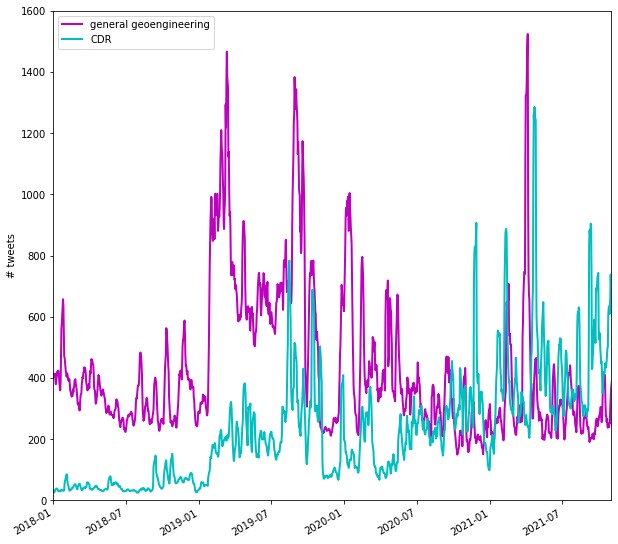

In [71]:
# plot daily tweet counts for keywords with rolling average
cdr_keywords = ['"ghg removal"',  '"greenhouse gas removal"', '"carbon dioxide sequestration"',
        '"co2 sequestration"', '"co2 removal"', '"carbon dioxide removal"', 
        '"negative emissions"', '"carbon removal"', '"carbon sequestration"']

geoeng_keywords = ['"planetary engineering"', '"climate engineering"', 'geoengineering']

fig, ax = plt.subplots(1, 1, figsize=(10,10))
#daily_counts_df[geoeng_keywords].sum(1).plot(ax=ax)
daily_counts_df[geoeng_keywords].sum(1).rolling(window=7, center=True).mean().plot(ax=ax, c='m', linewidth=2)

#daily_counts_df[cdr_keywords].sum(1).plot(ax=ax)
daily_counts_df[cdr_keywords].sum(1).rolling(window=7, center=True).mean().plot(ax=ax, c='c', linewidth=2)

#ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('# tweets')
ax.set_ylim([0,1600])
ax.set_xlim([datetime(2018, 1, 1, 0, 0), datetime(2021,11, 1, 0, 0)])
#ax.set_xlim([datetime(2020, 9, 9, 0, 0), datetime(2020,9, 17, 0, 0)])
plt.legend(['general geoengineering', 'CDR'])
#ax.set_title("Tweets with general keywords")
plt.savefig("tweet_counts_geoeng+cdr_rolling.png", dpi=150, bbox_inches='tight')

# common hashtags

In [85]:
def hashtag_vectorizer(selected_tweets, count_by='day'):

    from sklearn.feature_extraction.text import CountVectorizer
    import re

    #regex = r'\s#.+?\s'
    #regex = r'(?:^|\B)(?!#[0-9_]+\b)(#[a-zA-Z0-9_]{1,30})(?:\b|\r)'
    regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'

    #print(re.findall(regex, '#testö. #best_ #99luftballons #90, #test_this #testbefore\r #test8\r #dn#test #d&w'))

    # hashtags can only contain alphanumeric characters + underscores, no spaces. Not only numbers.
    # https://help.twitter.com/en/using-twitter/replies-not-showing-up-and-hashtag-problems

    # "\#.+?\s" # default: default=r”(?u)\b\w\w+\b”
    # [ \b = word boundary (), (?u) switches on the re.U (re.UNICODE) flag for this expression.]
    # .+? is reluctant and consumes as few characters as it can.
    # lookahead: (?![0-9_]+\b) [not only numeric]
    # (?:) group not reported
    # Matches the empty string, but only when it is not at the beginning or end of a word.
    # This means that r'py\B' matches 'python', 'py3', 'py2', but not 'py', 'py.', or 'py!'.
    # \B is just the opposite of \b, so word characters in Unicode patterns are Unicode alphanumerics
    # or the underscore, although this can be changed by using the ASCII flag.
    # Word boundaries are determined by the current locale if the LOCALE flag is used.

    vectorizer =  CountVectorizer(min_df=1, token_pattern=regex)
    
    from django.contrib.postgres.aggregates import StringAgg

    if count_by == 'day':
        aggregated_texts = selected_tweets.annotate(
            day=TruncDay('created_at')).values('day').annotate(
            all_text=StringAgg('text', '\n'),
            count=Count('id')
        ).values('day', 'all_text', 'count')
    else:
        print('Specify a valid "count_by".')
        return 0

    texts = aggregated_texts.values_list("all_text", flat=True)
    tweet_counts = aggregated_texts.values('day', 'count')

    X = vectorizer.fit_transform(texts)
    features = vectorizer.get_feature_names()
    
    return X, features, tweet_counts

In [86]:
X, features, tweet_counts = hashtag_vectorizer(tweets.filter(text__isnull=False))

In [91]:
# calculate and save hashtag counts

sums = X.sum(axis=0)
countdf = pd.DataFrame({'feature': features, 'count': np.asarray(sums)[0]})
countdf = countdf.sort_values('count', ascending=False)
#countdf.to_csv('./results/top_hashtag_counts_all-byday.csv')
countdf['pct'] = 100*countdf['count'] / countdf['count'].sum()
countdf.reset_index(drop=True).head(10)

feature   count        pct
0       #geoengineering  586776  24.231112
1           #chemtrails  154376   6.375009
2            #fukushima  100315   4.142542
3         #opchemtrails   60084   2.481189
4        #climatechange   47035   1.942326
5                #haarp   35336   1.459212
6              #climate   33649   1.389547
7                  #srm   27304   1.127528
8  #weathermodification   19710   0.813931
9               #lookup   16807   0.694051

In [88]:
def top_hashtags_by_period(daycount_df, no_top=20, period_type='year'):
    # period_type can also be 'year'

    if period_type == 'year':
        # get yearly period objects
        periods = daycount_df['day'].dt.to_period('Y').unique()
    elif period_type == 'month':
        periods = daycount_df['day'].dt.to_period('M').unique()
    else:
        print('please choose "month" or "year" for period type')
        return 0

    top_hashtags_by_period = []
    all_top_hashtags = []

    for period in periods:

        daysofperiod = (period.start_time.tz_localize('UTC') <= daycount_df['day']) \
                        & (daycount_df['day'] <= period.end_time.tz_localize('UTC'))
        idx = daycount_df.loc[daysofperiod].index.tolist()
        # slice day - hashtag count matrix: https://cmdlinetips.com/2019/07/how-to-slice-rows-and-columns-of-sparse-matrix-in-python/
        hashtag_selected_days = pd.DataFrame({'feature': features_loaded,
                                          'count': np.asarray(hashtag_doc_matrix.tocsr()[idx].sum(axis=0))[0]})


        top_hashtags = hashtag_selected_days.sort_values('count', ascending=False).head(no_top)['feature'].tolist()
        top_hashtags_counts = hashtag_selected_days.sort_values('count', ascending=False).head(no_top)['count'].tolist()

        top_hashtags_by_period.append({'period': period,
                                       'no days': len(daycount_df.iloc[idx]),
                                       'top {}'.format(no_top): ', '.join(top_hashtags),
                                       'top {} counts'.format(no_top): top_hashtags_counts})

        all_top_hashtags.append(top_hashtags)


    return pd.DataFrame(top_hashtags_by_period)

In [92]:
features_loaded = features
daycount_df = pd.DataFrame(tweet_counts)
hashtag_doc_matrix = X

In [93]:
pd.set_option("max_colwidth", 500)
top_hashtags = top_hashtags_by_period(daycount_df, period_type='year')
#top_hashtags.to_csv('./results/top_hashtags_by_year.csv')
top_hashtags

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


period  no days  \
0    2009       57   
1    2010      365   
2    2011      365   
3    2012      366   
4    2013      365   
5    2014      365   
6    2015      365   
7    2016      366   
8    2017      365   
9    2018      365   
10   2019      365   
11   2020      366   
12   2021      311   

                                                                                                                                                                                                                                                                            top 20  \
0                                                        #geoengineering, #cop15, #climate, #biochar, #carbon, #sequestration, #climatechange, #green, #copenhagen, #agu09, #energy, #eco, #weather, #education, #chemtrails, #ccs, #news, #secondlife, #globalwarming, #cleantech   
1                                                                    #geoengineering, #chemtrails, #climate, #globaldimming, #green, #climatechange, #chemtrail, #environment, #science, #news, #tcot, #carbon, #eco, #tlot, #oilspill, #becktips, #agw, #energy, #glennbeck, #gmo   
2                                                           #geoengineering, #chemtrails, #climate, #climatechange, #environment, #news, #haarp, #carbon, #chemtrail, #nwo, #green, #weather, #science, #sustainability, #health, #infowars, #globalwarming, #tcot, #brighton, #uk   
3                                  #geoengineering, #chemtrails, #climate, #climatechange, #nwo, #haarp, #weather, #news, #environment, #chemtrail, #science, #weathermodification, #brighton, #global, #uk, #carbon, #globalwarming, #technologies, #anthropogenic, #temperatures   
4                          #geoengineering, #chemtrails, #climate, #climatechange, #haarp, #nwo, #chemtrail, #weathermodification, #srm, #weather, #news, #nexrad, #science, #global, #environment, #globalwarming, #twitterpetition, #anthropogenic, #technologies, #temperatures   
5                                            #geoengineering, #chemtrails, #twitterpetition, #climate, #opchemtrails, #haarp, #climatechange, #science, #tech, #srm, #energy, #debate, #lookup, #weathermodification, #skyderalert, #hng, #chemtrail, #weather, #nwo, #environment   
6                                           #geoengineering, #chemtrails, #opchemtrails, #climate, #climatechange, #srm, #haarp, #science, #cop21, #tech, #energy, #agenda21, #weathermodification, #enmod, #realclimateleadership, #weather, #environment, #debate, #lookup, #hng   
7                                                            #geoengineering, #chemtrails, #opchemtrails, #haarp, #climate, #nwo, #opchempba, #srm, #climatechange, #sheeple, #science, #tech, #debate, #weathermodification, #hng, #lookup, #energy, #enviro, #agenda21, #weather   
8                                         #geoengineering, #fukushima, #chemtrails, #opchemtrails, #opchempba, #haarp, #climatechange, #srm, #climate, #depopulation, #news, #alsace, #weathermodification, #ca, #cancer, #sixthmassextinction, #chernobyl, #hng, #lookup, #nexrad   
9           #geoengineering, #chemtrails, #climatechange, #srm, #lookup, #wedonotconsent, #maga, #haarp, #nexrad, #opchemtrails, #idonotconsent, #silentwarfare, #opstopchemtrails, #bigmoney, #skybastard, #cloudseeding, #potus, #weathermodification, #climate, #weatherwarfare   
10                               #geoengineering, #chemtrails, #climatechange, #weathermodification, #weatherwarfare, #wedonotconsent, #haarp, #opchemtrails, #engineering, #climate, #jobs, #planetary, #srm, #lookup, #weather, #5g, #whales, #agenda21, #ケムトレイル, #globalwarming   
11    #geoengineering, #chemtrails, #climatechange, #5g, #weatherwarfare, #haarp, #carbon, #wedonotconsent, #weathermodification, #srm, #climate, #aerosolsprayingcrimes, #agenda21, #smartdust, #chemtrail, #weathermanipulation, #33milpies, #nwo, #antinwo, #militaryexperiment   
12  #geoengineering, #chemtrails, #climatechange, #carbon, #climate, #haarp, #cl

# look into peaks

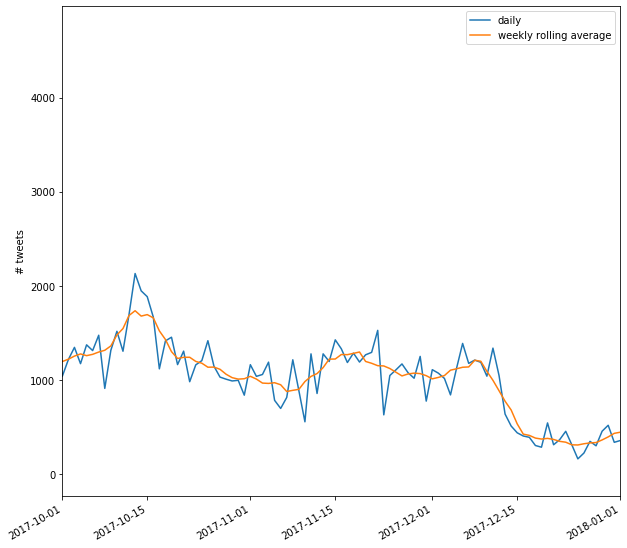

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
daily_counts_df.sum(1).plot(ax=ax)
daily_counts_df.sum(1).rolling(window=7, center=True).mean().plot(ax=ax)

#ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('# tweets')
ax.set_xlim([datetime(2017, 10, 1, 0, 0), datetime(2018, 1, 1, 0, 0)])
#ax.set_xlim([datetime(2020, 9, 9, 0, 0), datetime(2020,9, 17, 0, 0)])
#ax.set_ylim([0, 4000])
plt.legend(['daily', 'weekly rolling average'])
#ax.set_title("Tweets with general keywords")
plt.savefig("tweet_counts_geoengineering_daily.png", dpi=150, bbox_inches='tight')

In [82]:
filtered_tweets = tweets.filter(created_at__gte = datetime(2017, 10, 1, 0, 0), created_at__lte=datetime(2018, 11, 1, 0, 0))

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField TwitterBaseModel.created_at received a naive datetime (2017-10-01 00:00:00) while time zone support is active.
  RuntimeWarning)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/django/db/models/fields/__init__.py:1427: RuntimeWarning: DateTimeField TwitterBaseModel.created_at received a naive datetime (2018-11-01 00:00:00) while time zone support is active.
  RuntimeWarning)


In [83]:
filtered_tweets[:100].values_list("text")

<QuerySet [("They can't hide their lying skies... and their smiles are a thin disguise... #Chemtrails #geoengineering #globalcoolingLIES #ANTI_Life #TheyAreKillingTheEarth pic.twitter.com/ZmhyZeHXtm",), ('https://t.co/MCj2NIrkTd  .#OpChemtrails #Geoengineering',), ('Geoengineering Watch Global Alert News, December 30, 2017, #125 ( Dane W...  https://youtu.be/gnEDxlKgo3w\xa0 via @YouTube',), ('Geoengineering Watch Global Alert News: December 30, 2017 https://t.co/BYEG3AW9wh',), ('Weather Wars; Geoengineering on a Massive Scale from the Ground Up  https://youtu.be/_dLZfTSM6PU\xa0 via @YouTube',), ('Geoengineering Watch Global Alert News, December 30, 2017, #125 ( Dane Wigington )  https://fb.me/ylJ3sGDr\xa0',), ('Chemtrails and storm weather pics through HDR, late December 2017, Turkey  https://youtu.be/hnDlscBqwyQ\xa0 #TruthSeekers #Geoengineering #CloudSeeding #Sun #SaveOurBlueSkies #SoBS #TwitterStorm',), ('Geoengineering Watch Global Alert News: December 30, 2017: Source: Dane Wiging